In [62]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
import json

def csv_to_xml(csv_file, output_directory):
    # Create the output directory if it does not already exist
    os.makedirs(output_directory, exist_ok=True)

    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        filename = row['filename']  # Extract the filename from the row
        # Parse the shape and attribute JSON fields from the row
        shape_attrs = json.loads(row['region_shape_attributes'].replace("'", '"'))
        attributes = json.loads(row['region_attributes'].replace("'", '"'))

        # Create the root XML element 'annotation'
        annotation = ET.Element('annotation')

        # Create and append the 'folder' element to 'annotation'
        folder = ET.SubElement(annotation, 'folder')
        folder.text = 'images'

        # Create and append the 'filename' element to 'annotation'
        filename_elem = ET.SubElement(annotation, 'filename')
        filename_elem.text = filename

        # Create and append the 'path' element to 'annotation'
        path_elem = ET.SubElement(annotation, 'path')
        path_elem.text = os.path.join('images', filename)

        # Create and append the 'source' element with its child 'database'
        source = ET.SubElement(annotation, 'source')
        database = ET.SubElement(source, 'database')
        database.text = 'Unknown'

        # Create and append the 'size' element with dummy values for width, height, and depth
        size = ET.SubElement(annotation, 'size')
        width = ET.SubElement(size, 'width')
        height = ET.SubElement(size, 'height')
        depth = ET.SubElement(size, 'depth')
        width.text = '0'  # Dummy value for width
        height.text = '0'  # Dummy value for height
        depth.text = '3'  # Depth value for RGB images (3 channels)

        # Create and append the 'segmented' element
        segmented = ET.SubElement(annotation, 'segmented')
        segmented.text = '0'

        # Create and append the 'object' element
        obj = ET.SubElement(annotation, 'object')

        # Create and append the 'name' element to 'object'
        name = ET.SubElement(obj, 'name')
        name.text = attributes.get('name', 'Unknown')

        # Create and append the 'pose' element
        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'

        # Create and append the 'truncated' element
        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = '0'

        # Create and append the 'difficult' element
        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = '0'

        # Check the shape type and add corresponding elements
        if shape_attrs['name'] == 'rect':
            # If shape is a rectangle, add bounding box information
            bndbox = ET.SubElement(obj, 'bndbox')
            xmin = ET.SubElement(bndbox, 'xmin')
            ymin = ET.SubElement(bndbox, 'ymin')
            xmax = ET.SubElement(bndbox, 'xmax')
            ymax = ET.SubElement(bndbox, 'ymax')

            # Set the bounding box coordinates
            xmin.text = str(shape_attrs['x'])
            ymin.text = str(shape_attrs['y'])
            xmax.text = str(shape_attrs['x'] + shape_attrs['width'])
            ymax.text = str(shape_attrs['y'] + shape_attrs['height'])

        elif shape_attrs['name'] == 'point':
            # If shape is a point, add keypoints information
            keypoints = ET.SubElement(obj, 'keypoints')
            keypoint = ET.SubElement(keypoints, 'keypoint')

            cx = ET.SubElement(keypoint, 'cx')
            cy = ET.SubElement(keypoint, 'cy')

            # Set the keypoint coordinates
            cx.text = str(shape_attrs['cx'])
            cy.text = str(shape_attrs['cy'])

        # Write the XML tree to a file
        tree = ET.ElementTree(annotation)
        xml_path = os.path.join(output_directory, filename.replace('.png', '.xml'))
        tree.write(xml_path)

# Example usage
csv_file = '/content/anotations_csv.csv'  # Path to the input CSV file
output_directory = '/content/annotations_xml'  # Directory where XML files will be saved

# Call the function to convert CSV to XML
csv_to_xml(csv_file, output_directory)


In [80]:
import torch
from PIL import Image
import os
import xml.etree.ElementTree as ET
from torchvision import transforms
from torch.utils.data import DataLoader

class YoloDataset(torch.utils.data.Dataset):
    """
    A custom PyTorch Dataset class for loading images and their corresponding annotations.
    This dataset assumes annotations are in XML format (e.g., VOC format).
    """

    def __init__(self, image_dir, annotations_dir, label_map, transform=None):
        """
        Initialize the dataset with directory paths, label map, and optional transforms.

        Parameters:
        - image_dir (str): Directory containing the images.
        - annotations_dir (str): Directory containing the XML annotation files.
        - label_map (dict): A dictionary mapping class names to integer labels.
        - transform (callable, optional): A function/transform to apply to the images and targets.
        """
        self.image_dir = image_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.label_map = label_map
        # List all PNG image files in the image directory
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        print(f"Found {len(self.image_files)} images")

    def __len__(self):
        """
        Return the total number of images in the dataset.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Retrieve the image and its corresponding annotation at the specified index.

        Parameters:
        - idx (int): Index of the image and annotation to retrieve.

        Returns:
        - image (PIL.Image): The image at the specified index.
        - target (dict): A dictionary containing bounding boxes and labels.
        """
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        ann_file = img_file.replace('.png', '.xml')
        ann_path = os.path.join(self.annotations_dir, ann_file)

        # Debugging information
        print(f"Processing image: {img_path}")
        print(f"Looking for annotations: {ann_path}")

        # Load image
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        # Store original dimensions
        old_w, old_h = image.size

        # Initialize lists for boxes and labels
        boxes = []
        labels = []

        # Load annotations from XML
        if os.path.exists(ann_path):
            tree = ET.parse(ann_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                label = obj.find('name').text
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Refine bounding box coordinates
                margin = 2  # Adjust margin as needed
                xmin = max(0, xmin - margin)
                ymin = max(0, ymin - margin)
                xmax = min(old_w, xmax + margin)
                ymax = min(old_h, ymax + margin)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.label_map.get(label, -1))  # Use -1 if label is not found

        else:
            print(f"Annotation file not found: {ann_path}")

        # Check if boxes and labels were loaded
        if not boxes:
            print(f"No boxes found for image: {img_path}")

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create target dictionary
        target = {'boxes': boxes, 'labels': labels}

        # Apply transforms if provided
        if self.transform:
            # Save original dimensions before transformation
            orig_img = image
            image = self.transform(image)

            # Retrieve new dimensions after transformation
            new_w, new_h = image.size if isinstance(image, Image.Image) else image.shape[2], image.shape[1]

            # Adjust bounding boxes
            if isinstance(image, Image.Image):
                # If image is still a PIL Image, use size
                new_w, new_h = image.size
            else:
                # If image is a tensor, use shape
                new_w, new_h = image.shape[2], image.shape[1]

            boxes = [[x1 * new_w / old_w, y1 * new_h / old_h, x2 * new_w / old_w, y2 * new_h / old_h]
                     for (x1, y1, x2, y2) in boxes]
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            target = {'boxes': boxes, 'labels': labels}

        return image, target

# Define a transformation pipeline
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize to (height, width)
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor and normalize to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Define the label map (adjust as needed)
label_map = {'dog': 1}  # Add more labels if necessary

# Paths to image and annotation directories
image_dir = '/content/image'
annotations_dir = '/content/annotations_xml'

# Create dataset with the transformation
dataset = YoloDataset(image_dir, annotations_dir, label_map=label_map, transform=transform)

# DataLoader to handle batching and shuffling
def collate_fn(batch):
    """
    Custom collate function to handle batching of images and targets.

    Parameters:
    - batch (list of tuples): A list where each element is a tuple (image, target).

    Returns:
    - images (list): A list of images.
    - targets (list): A list of target dictionaries.
    """
    images, targets = zip(*batch)
    images = [img for img in images]
    targets = [{k: v for k, v in t.items()} for t in targets]
    return images, targets

# Set batch_size to 15 to process 15 images at a time
dataloader = DataLoader(dataset, batch_size=15, shuffle=True, collate_fn=collate_fn)

# Verify the DataLoader by printing the number of images and targets loaded
for images, targets in dataloader:
    print(f'Loaded {len(images)} images and {len(targets)} targets')
    break


Found 16 images
Processing image: /content/image/Img4.png
Looking for annotations: /content/annotations_xml/Img4.xml
Processing image: /content/image/Img2.png
Looking for annotations: /content/annotations_xml/Img2.xml
Processing image: /content/image/Img7.png
Looking for annotations: /content/annotations_xml/Img7.xml
Processing image: /content/image/Img12.png
Looking for annotations: /content/annotations_xml/Img12.xml
Processing image: /content/image/Img1.png
Looking for annotations: /content/annotations_xml/Img1.xml
Processing image: /content/image/Img10.png
Looking for annotations: /content/annotations_xml/Img10.xml
Processing image: /content/image/Img8.png
Looking for annotations: /content/annotations_xml/Img8.xml
Processing image: /content/image/Img11.png
Looking for annotations: /content/annotations_xml/Img11.xml
Processing image: /content/image/Img5.png
Looking for annotations: /content/annotations_xml/Img5.xml
Processing image: /content/image/Img9.png
Looking for annotations: /c

In [66]:
#Import SSD Model

from torchvision.models.detection import ssdlite320_mobilenet_v3_large


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


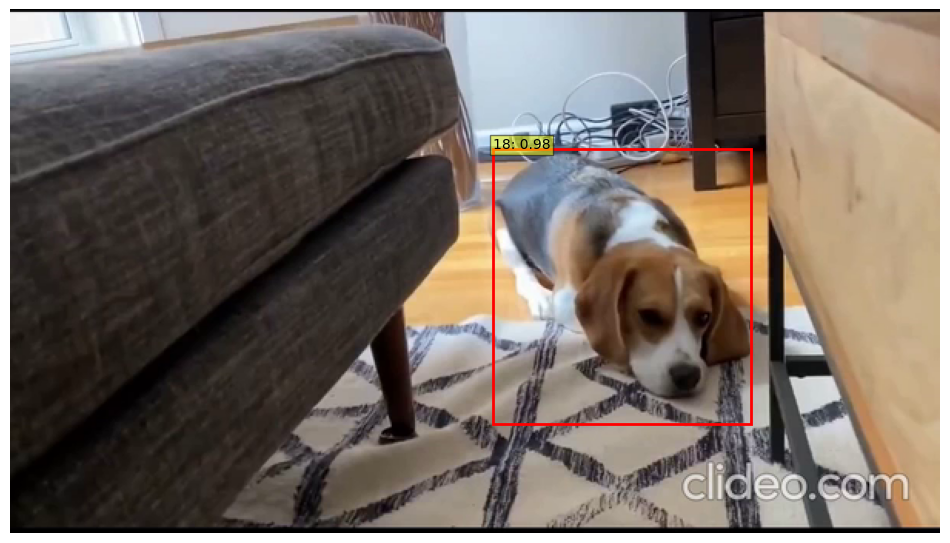

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as T
from torchvision.models.detection import ssdlite320_mobilenet_v3_large

# Load the pre-trained SSD model for object detection
model = ssdlite320_mobilenet_v3_large(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image_np):
    """
    Detect faces in an image using Haar Cascade.

    Parameters:
    - image_np (numpy.ndarray): Input image in numpy array format.

    Returns:
    - faces (list of tuples): List of bounding boxes around detected faces. Each bounding box is a tuple (x, y, w, h).
    """
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)  # Convert the image to grayscale
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

def visualize_inference(image_path):
    """
    Perform object detection on an image using SSD and visualize the results.
    Face detection is also performed on detected dog regions.

    Parameters:
    - image_path (str): Path to the input image.
    """
    # Load image and convert it to RGB format
    image = Image.open(image_path).convert('RGB')
    transform = T.ToTensor()  # Define a transform to convert the image to a tensor
    image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

    with torch.no_grad():  # Disable gradient calculations
        # Perform object detection using the SSD model
        predictions = model(image_tensor)

    # Extract bounding boxes, labels, and scores from the predictions
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Convert image from tensor to numpy array for visualization
    image_np = np.array(image)

    # Create a plot for visualization
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    ax = plt.gca()

    # Draw bounding boxes and labels on the image
    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Threshold for displaying the box
            x0, y0, x1, y1 = box
            rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            plt.text(x0, y0, f'{label}: {score:.2f}', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 2})

            # Crop detected dog regions
            cropped_img = image_np[int(y0):int(y1), int(x0):int(x1)]
            faces = detect_faces(cropped_img)
            for (x, y, w, h) in faces:
                # Draw bounding boxes around detected faces within the detected dog region
                plt.gca().add_patch(plt.Rectangle((x0 + x, y0 + y), w, h, fill=False, edgecolor='blue', linewidth=2))
                plt.text(x0 + x, y0 + y, 'Dog Face', bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 2})

    plt.axis('off')  # Turn off axis
    plt.show()  # Display the plot

# Path to your image
image_path = '/content/Images/img0427.png'
visualize_inference(image_path)


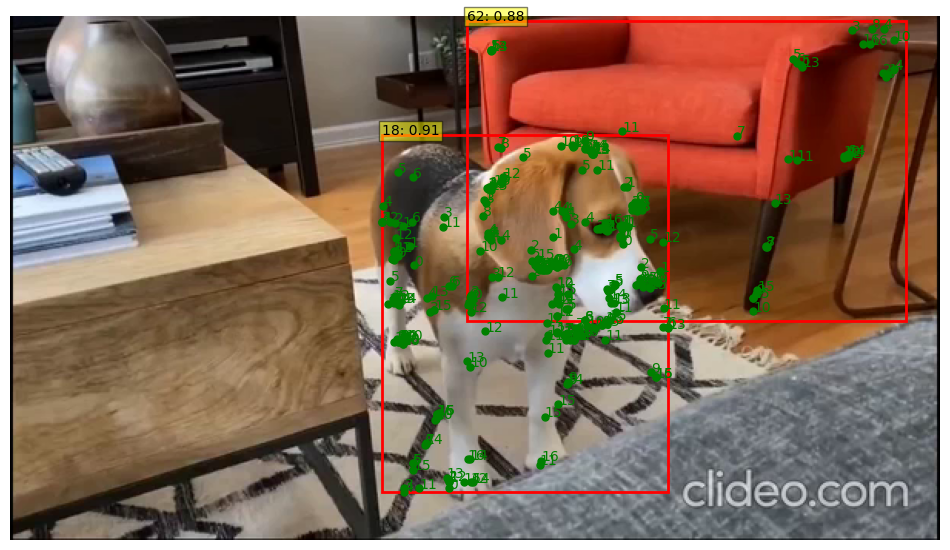

In [71]:
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the pre-trained SSD model
ssd_model = ssdlite320_mobilenet_v3_large(pretrained=True)
ssd_model.eval()

# Load the pre-trained Pose Estimation model
pose_model = keypointrcnn_resnet50_fpn(pretrained=True)
pose_model.eval()

def detect_dogs(image_tensor):
    """
    Perform object detection to identify dogs in the image tensor.

    Parameters:
        image_tensor (torch.Tensor): Tensor representation of the image.

    Returns:
        dict: Detection results containing bounding boxes, labels, and scores.
    """
    with torch.no_grad():
        predictions = ssd_model(image_tensor)
    return predictions[0]

def pose_estimation(image_tensor):
    """
    Perform pose estimation to detect keypoints on the detected dog regions.

    Parameters:
        image_tensor (torch.Tensor): Tensor representation of the image region containing a dog.

    Returns:
        dict: Pose estimation results containing keypoints.
    """
    with torch.no_grad():
        predictions = pose_model(image_tensor)
    return predictions[0]

def visualize_inference(image_path):
    """
    Load an image, perform object detection, and visualize results with bounding boxes and keypoints.

    Parameters:
        image_path (str): Path to the input image file.
    """
    # Load image and convert to tensor
    image = Image.open(image_path).convert('RGB')
    transform = ToTensor()
    image_tensor = transform(image).unsqueeze(0)

    # Perform object detection
    ssd_predictions = detect_dogs(image_tensor)

    boxes = ssd_predictions['boxes'].cpu().numpy()
    labels = ssd_predictions['labels'].cpu().numpy()
    scores = ssd_predictions['scores'].cpu().numpy()

    # Convert image to numpy array for visualization
    image_np = np.array(image)

    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Only consider predictions with score > 0.5
            x0, y0, x1, y1 = box
            rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            plt.text(x0, y0, f'{label}: {score:.2f}', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 2})

            # Crop detected dog regions
            cropped_img = image_np[int(y0):int(y1), int(x0):int(x1)]
            cropped_img_pil = Image.fromarray(cropped_img)
            cropped_img_tensor = transform(cropped_img_pil).unsqueeze(0)

            # Perform pose estimation on the cropped dog regions
            pose_predictions = pose_estimation(cropped_img_tensor)
            keypoints = pose_predictions['keypoints'].cpu().numpy()

            for kpt in keypoints:
                for i in range(kpt.shape[0]):
                    x_kpt, y_kpt, _ = kpt[i]
                    if x_kpt > 0 and y_kpt > 0:  # Filter out invalid keypoints
                        plt.plot(x0 + x_kpt, y0 + y_kpt, 'o', color='green', markersize=5)
                        plt.text(x0 + x_kpt, y0 + y_kpt, f'{i}', color='green')

    plt.axis('off')
    plt.show()

# Path to your image
image_path = '/content/Images/img0007.png'
visualize_inference(image_path)


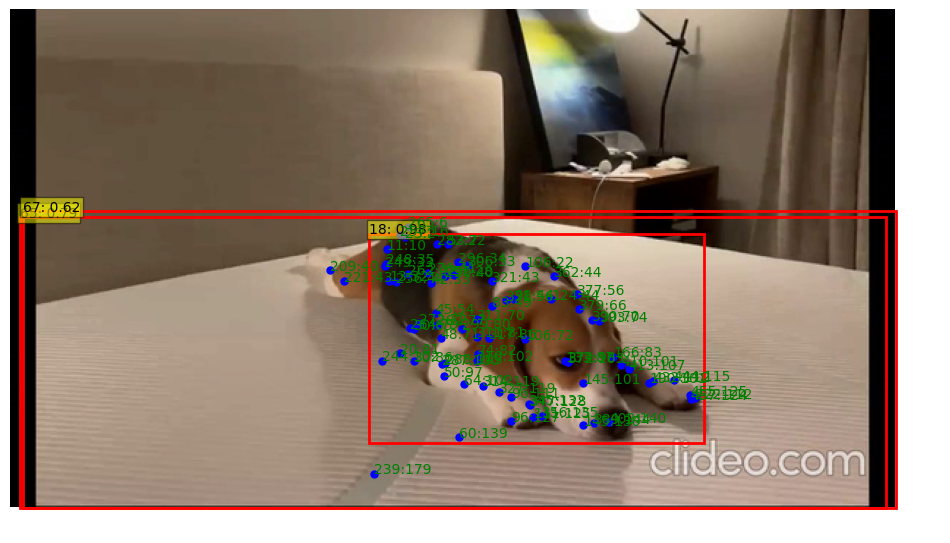

In [78]:
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import DBSCAN

# Load the pre-trained SSD model
ssd_model = ssdlite320_mobilenet_v3_large(pretrained=True)
ssd_model.eval()

# Load the pre-trained Pose Estimation model
pose_model = keypointrcnn_resnet50_fpn(pretrained=True)
pose_model.eval()

def detect_dogs(image_tensor):
    """
    Perform object detection to identify dogs in the image tensor using the SSD model.

    Parameters:
        image_tensor (torch.Tensor): Tensor representation of the image.

    Returns:
        dict: Detection results including bounding boxes, labels, and scores.
    """
    with torch.no_grad():
        predictions = ssd_model(image_tensor)
    return predictions[0]

def pose_estimation(image_tensor):
    """
    Perform pose estimation to detect keypoints on the detected dog regions using the Pose Estimation model.

    Parameters:
        image_tensor (torch.Tensor): Tensor representation of the image region containing a dog.

    Returns:
        dict: Pose estimation results including keypoints.
    """
    with torch.no_grad():
        predictions = pose_model(image_tensor)
    return predictions[0]

def cluster_keypoints(keypoints, eps=10, min_samples=1):
    """
    Cluster detected keypoints using DBSCAN clustering algorithm.

    Parameters:
        keypoints (list of np.ndarray): List of keypoints arrays for detected objects.
        eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        np.ndarray: Array of clustered keypoints with coordinates averaged for each cluster.
    """
    # Flatten keypoints and perform clustering
    keypoints_flat = np.vstack([kp.reshape(-1, 3)[:, :2] for kp in keypoints])
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(keypoints_flat)

    clustered_keypoints = []
    for label in np.unique(clustering.labels_):
        cluster_kps = keypoints_flat[clustering.labels_ == label]
        if cluster_kps.size > 0:
            clustered_keypoints.append(np.mean(cluster_kps, axis=0))

    return np.array(clustered_keypoints)

def visualize_inference(image_path):
    """
    Load an image, perform object detection, pose estimation, and visualize the results with bounding boxes and keypoints.

    Parameters:
        image_path (str): Path to the input image file.
    """
    # Load image and convert to tensor
    image = Image.open(image_path).convert('RGB')
    transform = ToTensor()
    image_tensor = transform(image).unsqueeze(0)

    # Perform object detection
    ssd_predictions = detect_dogs(image_tensor)

    boxes = ssd_predictions['boxes'].cpu().numpy()
    labels = ssd_predictions['labels'].cpu().numpy()
    scores = ssd_predictions['scores'].cpu().numpy()

    # Convert image to numpy array for visualization
    image_np = np.array(image)

    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Only consider predictions with score > 0.5
            x0, y0, x1, y1 = box
            rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            plt.text(x0, y0, f'{label}: {score:.2f}', bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 2})

            # Crop detected dog regions
            cropped_img = image_np[int(y0):int(y1), int(x0):int(x1)]
            cropped_img_pil = Image.fromarray(cropped_img)
            cropped_img_tensor = transform(cropped_img_pil).unsqueeze(0)

            # Perform pose estimation on the cropped dog regions
            pose_predictions = pose_estimation(cropped_img_tensor)
            keypoints = pose_predictions['keypoints'].cpu().numpy()

            # Cluster keypoints
            clustered_keypoints = cluster_keypoints(keypoints)

            for kpt in clustered_keypoints:
                x_kpt, y_kpt = kpt
                if x_kpt > 0 and y_kpt > 0:  # Filter out invalid keypoints
                    plt.plot(x0 + x_kpt, y0 + y_kpt, 'o', color='blue', markersize=5)
                    plt.text(x0 + x_kpt, y0 + y_kpt, f'{int(x_kpt)}:{int(y_kpt)}', color='green')

    plt.axis('off')
    plt.show()

# Path to your image
image_path = '/content/Images/img1567.png'
visualize_inference(image_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRC

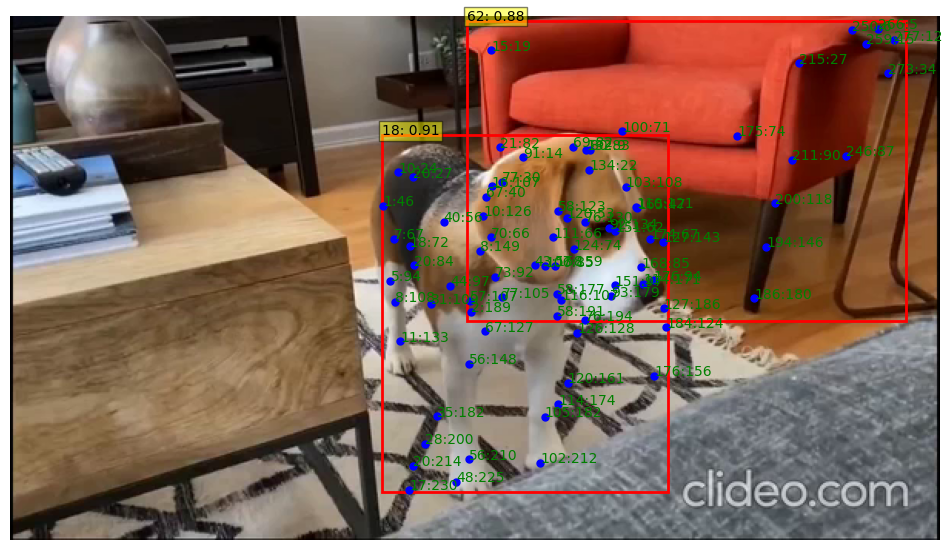

In [73]:
# Path to your image
image_path = '/content/Images/img0007.png'
visualize_inference(image_path)


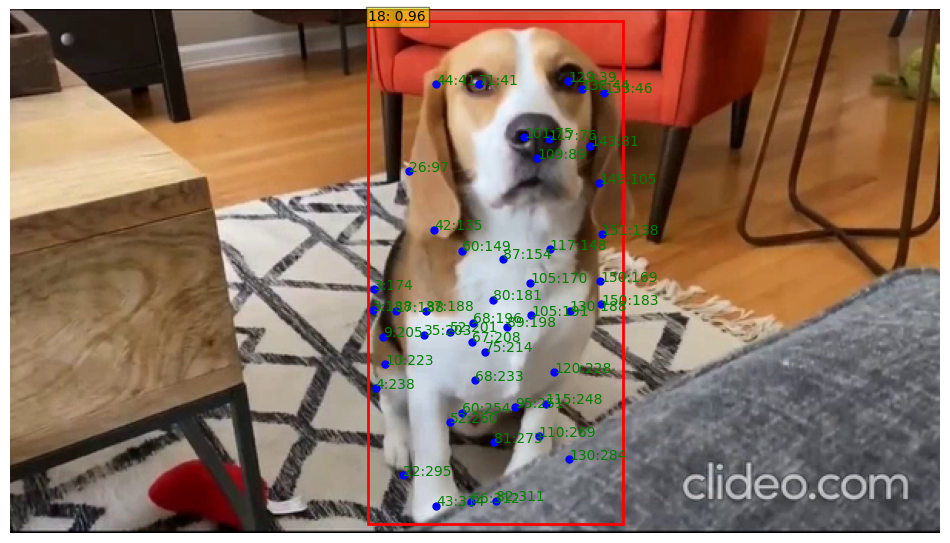

In [74]:
# Path to your image
image_path = '/content/Images/img0106.png'
visualize_inference(image_path)


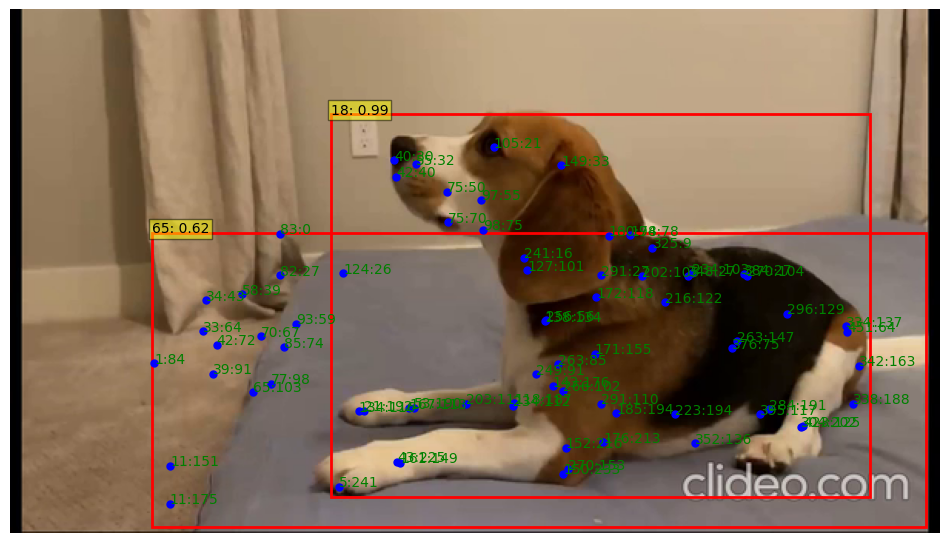

In [76]:
# Path to your image
image_path = '/content/Images/img1773.png'
visualize_inference(image_path)
